In [1]:
import numpy               as np
import matplotlib.pyplot   as plt
import matplotlib.pyplot   as pp # we will merge these
import pandas              as pd
import seaborn             as sb

from datetime              import timedelta 

from sklearn               import metrics
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn.mixture       import GaussianMixture
from sklearn.linear_model  import LinearRegression

from matplotlib.colors     import LogNorm

from IPython.display       import HTML, Markdown

from sklearn.metrics       import mean_squared_error

%matplotlib inline

np.random.seed(0)

import os
print(os.listdir("./input"))

['historical_transactions.csv', '.ipynb_checkpoints', 'new_merchant_transactions.csv', '.~lock.Data_Dictionary.xlsx#', 'merchants.csv', 'sample_submission.csv', 'test.csv', 'Data_Dictionary.xlsx', '.gitignore', 'train.csv']


# Helper Functions

In [2]:
def color(text, color = 'red', background = 'transparent', weight = 'normal') :
    return f'<span style="color:{color};background:{background};font-weight:{weight}">{text}</span>'

def mark(*objects, sep = ' ') :
    return display(Markdown(sep.join(str(o) for o in objects)))

def line(header = '') :
    
    return mark('<hr/>')

mark('<b>hi</b>', [1,2,3], color('hello world', weight = 'bold'), color('!!!', weight = 'bold', background = 'black'))
line()

<b>hi</b> [1, 2, 3] <span style="color:red;background:transparent;font-weight:bold">hello world</span> <span style="color:red;background:black;font-weight:bold">!!!</span>

<hr/>

In [3]:
train        = pd.read_csv('input/train.csv', parse_dates=['first_active_month']).set_index('card_id')
test         = pd.read_csv('input/test.csv',  parse_dates=['first_active_month']).set_index('card_id')
merchants    = pd.read_csv('input/merchants.csv').set_index('merchant_id')
transactions_old = pd.read_csv('input/historical_transactions.csv',   parse_dates = ['purchase_date'])
transactions_new = pd.read_csv('input/new_merchant_transactions.csv', parse_dates = ['purchase_date'])

## Data Clean Up

In [4]:
# Row is missing value for first_active_month
print(test.loc['C_ID_c27b4f80f7', :])
test = test.drop(index='C_ID_c27b4f80f7')

first_active_month    NaT
feature_1               5
feature_2               2
feature_3               1
Name: C_ID_c27b4f80f7, dtype: object


# Exploratory Data Analysis

In [5]:
mark('<b>Code Book for Training Data</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'train', header = 2).style.hide_index())
line()

mark('<b>Code Book for Historical Transactions</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'history', header = 2).style.hide_index())
line()

mark('<b>Code Book for New Merchant Transactions</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'new_merchant_period', header = 2).style.hide_index())
line()

mark('<b>Code Book for Merchant Details</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'merchant', header = 2).style.hide_index())

<b>Code Book for Training Data</b>

Columns,Description
card_id,Unique card identifier
first_active_month,"'YYYY-MM', month of first purchase"
feature_1,Anonymized card categorical feature
feature_2,Anonymized card categorical feature
feature_3,Anonymized card categorical feature
target,Loyalty numerical score calculated 2 months after historical and evaluation period


<hr/>

<b>Code Book for Historical Transactions</b>

Columns,Description
card_id,Card identifier
month_lag,month lag to reference date
purchase_date,Purchase date
authorized_flag,"Y' if approved, 'N' if denied"
category_3,anonymized category
installments,number of installments of purchase
category_1,anonymized category
merchant_category_id,Merchant category identifier (anonymized )
subsector_id,Merchant category group identifier (anonymized )
merchant_id,Merchant identifier (anonymized)


<hr/>

<b>Code Book for New Merchant Transactions</b>

Columns,Description
card_id,Card identifier
month_lag,month lag to reference date
purchase_date,Purchase date
authorized_flag,"Y' if approved, 'N' if denied"
category_3,anonymized category
installments,number of installments of purchase
category_1,anonymized category
merchant_category_id,Merchant category identifier (anonymized )
subsector_id,Merchant category group identifier (anonymized )
merchant_id,Merchant identifier (anonymized)


<hr/>

<b>Code Book for Merchant Details</b>

Columns,Description
merchant_id,Unique merchant identifier
merchant_group_id,Merchant group (anonymized )
merchant_category_id,Unique identifier for merchant category (anonymized )
subsector_id,Merchant category group (anonymized )
numerical_1,anonymized measure
numerical_2,anonymized measure
category_1,anonymized category
most_recent_sales_range,Range of revenue (monetary units) in last active month --> A > B > C > D > E
most_recent_purchases_range,Range of quantity of transactions in last active month --> A > B > C > D > E
avg_sales_lag3,Monthly average of revenue in last 3 months divided by revenue in last active month


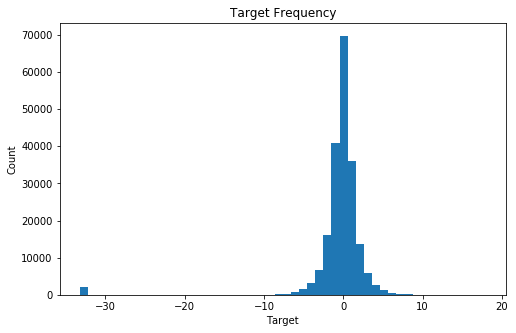

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(train.target.values, bins=50)
plt.title('Target Frequency')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


/home/khanna/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


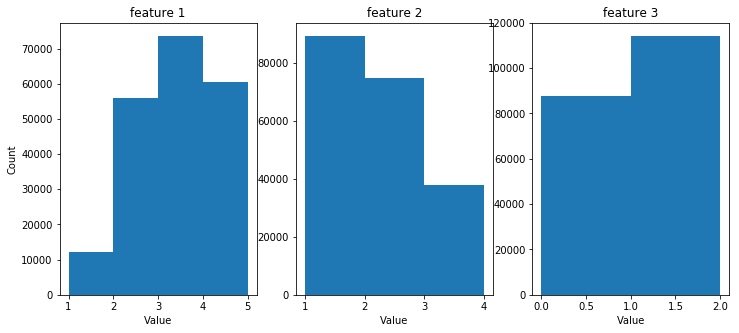

In [7]:

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12.0, 5.0))

ax1.hist(train.feature_1.values, bins=[1,2,3,4,5])
ax1.set_title('feature 1')
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')

ax2.hist(train.feature_2.values, bins=[1,2,3,4])
ax2.set_title('feature 2')
ax2.set_xlabel('Value')
# ax2.set_ylabel('Count')

ax3.hist(train.feature_3.values, bins=[0,1,2])
ax3.set_title('feature 3')
ax3.set_xlabel('Value')
# ax3.set_ylabel('Count')

fig1.show()

# Feature Engineering

## Transform train first_active_month to numeric
The first_active_month is a date the shopper first made a purchase using Elo.  Converting this to days would make it more useful for modelling. 

In [8]:
def first_active_month_to_numeric():
    global train, test
    latest_date = max(train['first_active_month'].max(), test['first_active_month'].max()) + timedelta(days=1)
    train['first_active_delta_days'] = ((latest_date - train['first_active_month']).dt.days)
    test['first_active_delta_days']  = ((latest_date - test['first_active_month']).dt.days)

first_active_month_to_numeric()
display(train.head())
display(test.head())



,first_active_month,feature_1,feature_2,feature_3,target,first_active_delta_days
card_id,,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820283,246
C_ID_3d0044924f,2017-01-01,4,1,0,0.392913,397
C_ID_d639edf6cd,2016-08-01,2,2,0,0.688056,550
C_ID_186d6a6901,2017-09-01,4,3,0,0.142495,154
C_ID_cdbd2c0db2,2017-11-01,1,3,0,-0.159749,93


,first_active_month,feature_1,feature_2,feature_3,first_active_delta_days
card_id,,,,,
C_ID_0ab67a22ab,2017-04-01,3,3,1,307
C_ID_130fd0cbdd,2017-01-01,2,3,0,397
C_ID_b709037bc5,2017-08-01,5,1,1,185
C_ID_d27d835a9f,2017-12-01,2,1,0,63
C_ID_2b5e3df5c2,2015-12-01,5,1,1,794


## Aggregate New and Old Transactions with Train on `card_id` 
see: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [9]:
def aggregate_data():
    global train, test
    
    # These aggregations will be performed on both new and old
    aggregation = {
#         'purchase_amount': ['sum', 'mean', 'median', 'max', 'min', 'std'],
        'purchase_amount': ['sum', 'mean'],
        'subsector_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'state_id': ['nunique']
    }
    
    # Do aggregations on aggregated_old and join with training and test data
    aggregated_old = transactions_old.groupby(['card_id']).agg(aggregation)
    aggregated_old.columns = ['old_' + '_'.join(col).strip() for col in aggregated_old.columns.values]
    train = train.merge(right=aggregated_old, how='left', on='card_id')
    test = test.merge(right=aggregated_old, how='left', on='card_id')

    # Do aggregations on aggregated_new and join with training and test data
    aggregated_new = transactions_new.groupby(['card_id']).agg(aggregation)
    aggregated_new.columns = ['new_' + '_'.join(col).strip() for col in aggregated_new.columns.values]
    train = train.merge(right=aggregated_new, how='left', on='card_id')
    test = test.merge(right=aggregated_new, how='left', on='card_id')
    
    # Joining the transaction_new with train created some empty cells
    # Fill them with zeros
    train = train.fillna(0)
    test = test.fillna(0)

    
aggregate_data()
display(train.head())
display(test.head())

,first_active_month,feature_1,feature_2,feature_3,target,first_active_delta_days,old_purchase_amount_sum,old_purchase_amount_mean,old_subsector_id_nunique,old_merchant_category_id_nunique,old_merchant_id_nunique,old_city_id_nunique,old_state_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_city_id_nunique,new_state_id_nunique
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820283,246,-165.968739,-0.638341,21,41,94,7,3,-13.244202,-0.575835,10.0,14.0,23.0,3.0,1.0
C_ID_3d0044924f,2017-01-01,4,1,0,0.392913,397,-210.006336,-0.600018,24,57,142,9,3,-4.355735,-0.725956,4.0,5.0,6.0,1.0,1.0
C_ID_d639edf6cd,2016-08-01,2,2,0,0.688056,550,-29.167391,-0.678311,7,8,13,5,2,-0.700326,-0.700326,1.0,1.0,1.0,1.0,1.0
C_ID_186d6a6901,2017-09-01,4,3,0,0.142495,154,-49.491364,-0.642745,13,25,50,7,5,-4.654372,-0.664910,5.0,6.0,7.0,2.0,2.0
C_ID_cdbd2c0db2,2017-11-01,1,3,0,-0.159749,93,-48.687656,-0.366073,17,26,66,6,6,-19.926237,-0.553507,10.0,17.0,36.0,5.0,5.0


,first_active_month,feature_1,feature_2,feature_3,first_active_delta_days,old_purchase_amount_sum,old_purchase_amount_mean,old_subsector_id_nunique,old_merchant_category_id_nunique,old_merchant_id_nunique,old_city_id_nunique,old_state_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_city_id_nunique,new_state_id_nunique
card_id,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,2017-04-01,3,3,1,307,-40.733733,-0.599025,12,16,24,7,3,-1.777156,-0.592385,3.0,3.0,3.0,3.0,1.0
C_ID_130fd0cbdd,2017-01-01,2,3,0,397,-49.136513,-0.629955,12,16,27,4,3,-5.944698,-0.660522,6.0,8.0,9.0,2.0,2.0
C_ID_b709037bc5,2017-08-01,5,1,1,185,4.528840,0.348372,6,8,9,4,4,0.180138,0.090069,2.0,2.0,2.0,2.0,2.0
C_ID_d27d835a9f,2017-12-01,2,1,0,63,-13.690715,-0.526566,11,18,23,1,1,-5.743674,-0.574367,8.0,10.0,10.0,3.0,3.0
C_ID_2b5e3df5c2,2015-12-01,5,1,1,794,25.139384,0.228540,15,31,47,5,4,12.064997,2.010833,4.0,5.0,6.0,2.0,2.0


# Feature Extraction
Analyze and select features for modeling

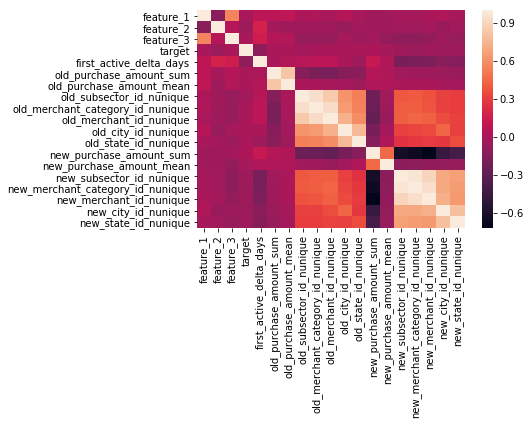

In [10]:
train_sm = train[train.columns[1:]][:1000]
corr = train_sm.corr()

sb.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Note the strong negative correlations to new_purchase_amount_sum. 
# I suspect this is because of the zero filled values when we joined
# train with transactions_new (which don't line up 1:1)

# Model
## Baseline

Our baseline model uses the data provided in the "train" dataset. 

In [11]:
def calculate_baseline():
    training = train[['feature_1', 'feature_2', 'feature_3', 'first_active_delta_days']]
    labels = train[['target']]

    data_len = len(training)
    mask = np.random.rand(data_len) < 0.8

    train_data = training.values[mask]
    train_labels = labels.values.flatten()[mask]
    test_data = training.values[~mask]
    test_labels = labels.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("After fitting Linear Regression, the baseline Mean Squared Error is: {:0.3f}".format(mse))
    print("The mean of our training label is {:0.3f} and for testing {:0.3f}".format(y_mean, y_test_mean))
    
    return mse

baseline_mse = calculate_baseline()

After fitting Linear Regression, the baseline Mean Squared Error is: 14.221
The mean of our training label is -0.394 and for testing -0.393


## Train and test model using engineered features 

In [12]:
def calculate_engineered():
    training = train[train.columns[1:]]
    del training['target']
    labels = train[['target']]
    
    data_len = len(training)
    mask = np.random.rand(data_len) < 0.8

    train_data = training.values[mask]
    train_labels = labels.values.flatten()[mask]
    test_data = training.values[~mask]
    test_labels = labels.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("After doing feature enginnering, the Mean Squared Error is: {:0.3f}".format(mse))
    
    return mse


engineered_mse = calculate_engineered()

After doing feature enginnering, the Mean Squared Error is: 15.007


In [13]:
delta_from_baseline = baseline_mse - engineered_mse
print("Our MSE of {:0.3f} is a change of {:0.3f} from our baseline MSE of {:0.3f}".format(engineered_mse, delta_from_baseline, baseline_mse))

Our MSE of 15.007 is a change of -0.785 from our baseline MSE of 14.221


In [14]:
def feature_play():
    #This is just to play around with different engineered features. 
    training = train[['feature_1', 'feature_2', 'feature_3', 
                      'first_active_delta_days', 'old_purchase_amount_mean',
                     'old_subsector_id_nunique', 'old_merchant_category_id_nunique', 
                      'old_merchant_id_nunique', 'old_city_id_nunique', 'old_state_id_nunique']]
    labels = train[['target']]
    
    data_len = len(training)
    mask = np.random.rand(data_len) < 0.8

    train_data = training.values[mask]
    train_labels = labels.values.flatten()[mask]
    test_data = training.values[~mask]
    test_labels = labels.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("After doing feature enginnering, the Mean Squared Error is: {:0.3f}".format(mse))
    
    return mse


play_mse = feature_play()

After doing feature enginnering, the Mean Squared Error is: 15.215
